# Basic Bot


In [1]:
!pip install langchain langchain-anthropic langchain_community langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found

In [2]:
import os
import getpass

os.environ["CLAUDE_API_KEY"] = getpass.getpass("CLAUDE API key:\n")

CLAUDE API key:
··········


In [3]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=os.getenv("CLAUDE_API_KEY"))

In [4]:
from typing import Annotated


from typing_extensions import TypedDict

# The StateGraph class is the main graph class to use.
# This is parameterized by a user defined State object.

from langgraph.graph import StateGraph

# Most modern LLM providers have a chat model interface that accepts a list of messages as input.
# LangChain's ChatModel in particular accepts a list of Message objects as inputs.
# These messages come in a variety of forms such as HumanMessage (user input) or AIMessage (LLM response).
from langgraph.graph.message import add_messages

# A StateGraph object defines the structure of our chatbot as a "state machine".
# We'll add nodes to represent the llm and functions our chatbot can call and
# edges to specify how the bot should transition between these functions.

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever the node is used.

# Nodes are typically python functions (sync or async) where the first positional argument is the state,
# and (optionally), the second positional argument is a "config",
# containing optional configurable parameters (such as a thread_id).
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

# Compiling provides a few basic checks on the structure of your graph (no orphaned nodes, etc).
# You MUST compile your graph before you can use it.
graph = graph_builder.compile()

LangGraph's underlying graph algorithm uses message passing to define a general program.

When a Node completes its operation, it sends messages along one or more edges to other node(s).

These recipient nodes then execute their functions, pass the resulting messages to the next set of nodes, and the process continues. Inspired by Google's Pregel system, the program proceeds in discrete **"super-steps."**

A **super-step** can be considered a single iteration over the graph nodes. **Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.**

At the start of graph execution, all nodes begin in an **inactive** state.

A node becomes **active** when it receives a new message (state) on any of its incoming **edges (or "channels")**.

The active node then runs its function and responds with updates. At the end of each super-step, nodes with no incoming messages vote to halt by marking themselves as inactive. The graph execution terminates when all nodes are inactive and no messages are in transit.

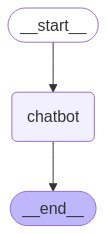

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

LangGraph is built with first class support for **streaming**, including streaming updates from graph nodes during the execution, streaming tokens from LLM calls and more.



There are three main types of data you’ll want to stream:

- Workflow progress (e.g., get state updates after each graph node is executed).
- LLM tokens as they’re generated.
- Custom updates (e.g., "Fetched 10/100 records")

**.stream** and **.astream** are sync and async methods for streaming back outputs from a graph run.

There are several different modes you can specify when calling these methods (e.g. `graph.stream(..., mode="...")):

- "values": This streams the full value of the state after each step of the graph.
- "updates": This streams the updates to the state after each step of the graph. If multiple updates are made in the same step (e.g. multiple nodes are run) then those updates are streamed separately.
- "custom": This streams custom data from inside your graph nodes.
- "messages": This streams LLM tokens and metadata for the graph node where LLM is invoked.

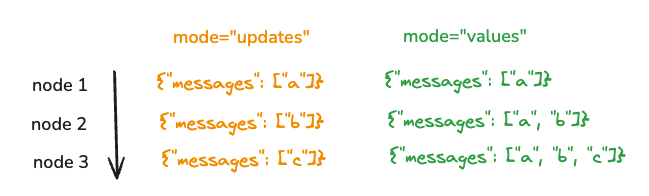

In [5]:
def stream_graph_updates(user_input: str):
  for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
    for value in event.values():
      print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: 
User: What do you know about LangGraph?
Assistant: # LangGraph

LangGraph is an open-source framework for building stateful, multi-actor applications with LLMs using a graph-based structure. It was developed by LangChain as an extension of their ecosystem.

Key features and aspects of LangGraph include:

- **Graph-based Architecture**: Allows for representing complex workflows as directed graphs with nodes (representing components or agents) and edges (representing flow of control and data)
- **Stateful Processing**: Maintains state across interactions, enabling multi-turn conversations and persistent memory
- **Agent Orchestration**: Designed for coordinating multiple AI agents that can work together on complex tasks
- **Python Integration**: Built to work seamlessly with Python and integrates with the broader LangChain ecosystem
- **Support for Loops and Conditional Logic**: Unlike simple sequential chains, LangGraph allows for loops, conditional branching, and complex control

# Adding Tools

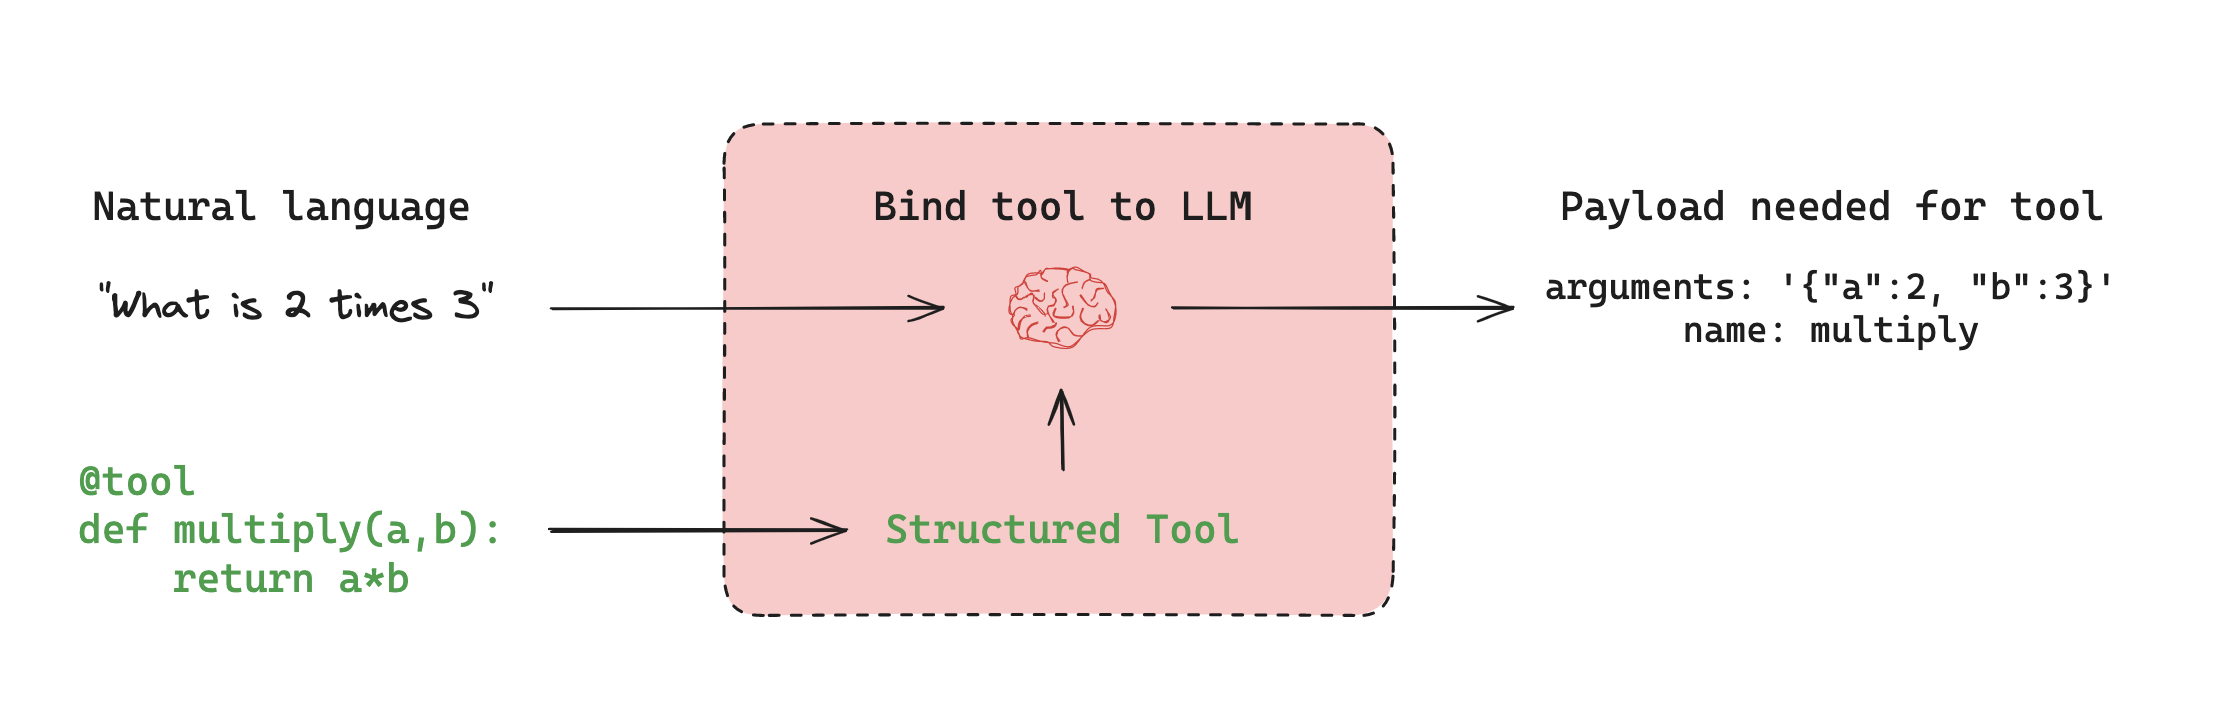

**Tools** are useful whenever you want an agent to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool, we give the model awareness of the required input schema.

The **model** will choose to call a tool based upon the natural language input from the user and it will return an output that adheres to the tool's required schema.



Many LLM providers support tool calling and tool calling interface in LangChain is simple: you can simply pass any Python function into ChatModel.bind_tools(function).

https://python.langchain.com/docs/integrations/chat/

In [6]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

Tavily API key:
··········


In [7]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

# ToolNode -> A node that runs the tools called in the last AIMessage.
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# If you want to optionally route to 1 or more edges (or optionally terminate),
# you can use the add_conditional_edges method.
# This method accepts the name of a node and a "routing function" to call after that node is executed.
# Similar to nodes, the routing_function accepts the current state of the graph and returns a value.

# tools_condition -> Function used in the conditional_edge to route to the ToolNode if the last message
# has tool calls. Otherwise, route to the end.

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

/tmp/ipython-input-57106805.py:18: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=2)


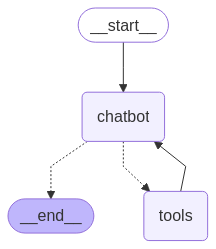

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
def stream_graph_updates(user_input: str):
      for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
          for value in event.values():
              print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: HI
Assistant: Hello! I'm here to help you with information, answer questions, or assist with research using my search capabilities. 

Is there something specific you'd like to know or a topic you'd like to explore? I can search for current events, help find information on various subjects, or answer questions you might have.

Feel free to ask me anything, and I'll do my best to provide helpful information.
User: 
User: What do you know about LangGraph?
Assistant: [{'text': "I'd be happy to provide you information about LangGraph. Let me search for the most up-to-date details about this technology.", 'type': 'text'}, {'id': 'toolu_01GXcrt1R28okzt5idVeQq64', 'input': {'query': 'LangGraph AI framework architecture features'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"title": "Understanding LangGraph: Key Concepts for Developing Agentic AI ...", "url": "https://sunnychopper.medium.com/understanding-langgraph-key-concepts-for-developing-agentic-ai-system

# Adding Memory

**Memory** is crucial for agents, enabling them to retain and utilize information across multiple steps of problem-solving. It operates on different scales:

- **Short-term memory**: Allows the agent to access information acquired during earlier steps in a sequence.
- **Long-term memory:** Enables the agent to recall information from previous interactions, such as past messages in a conversation.

**Short-term memory, or thread-scoped memory**, can be recalled at any time from within a single conversational thread with a user. LangGraph manages short-term memory as a part of your agent's state. State is persisted to a **database** using a **checkpointer** so the thread can be resumed at any time. Short-term memory updates when the graph is invoked or a step is completed, and the State is read at the start of each step.

**Long-term memory** is shared **across conversational threads**. It can be recalled at any time and in any thread. Memories are scoped to any **custom namespace**, **not just within a single thread ID**. LangGraph provides **stores** to let you save and recall long-term memories.

Both are important to understand and implement for your application.

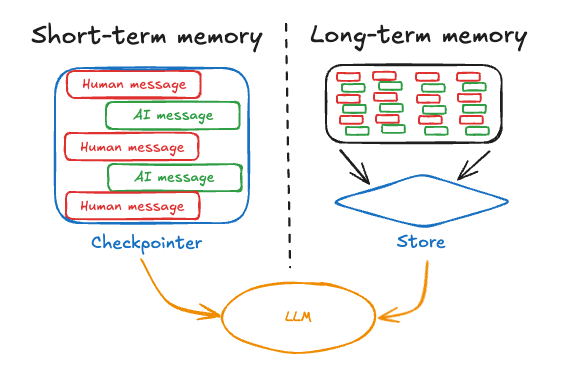

LangGraph provides full control over memory implementation:

- **State**: User-defined schema specifying the exact structure of memory to retain.
- **Checkpointers**: Mechanism to store state at every step across different interactions.

LangGraph has a **built-in persistence layer**, implemented through **checkpointers**. When you compile graph with a checkpointer, the checkpointer saves a checkpoint of the graph state.

Those checkpoints are saved to a **thread**, which can be accessed after graph execution.

Because threads allow access to graph's state after execution, several powerful capabilities including **human-in-the-loop, memory, time travel, and fault-tolerance** are all possible.

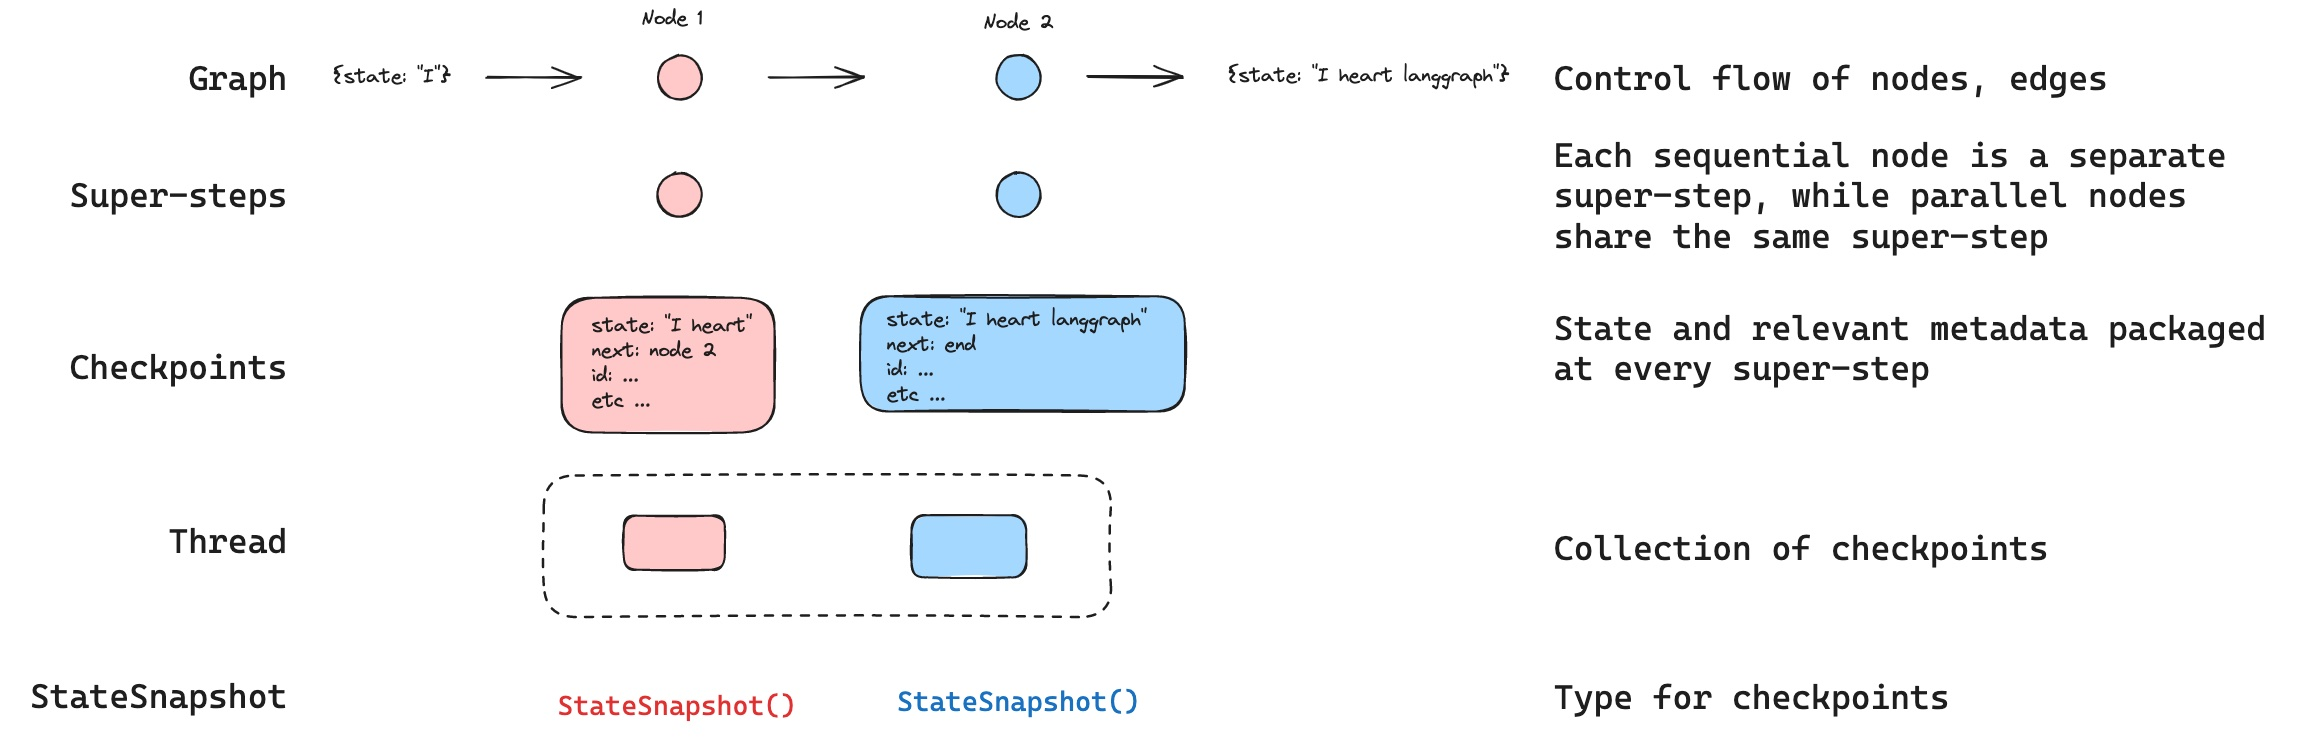

Checkpoint is a **snapshot of the graph state** saved and is represented by StateSnapshot object with the following key properties:

- config: Config associated with this checkpoint.
- metadata: Metadata associated with this checkpoint.
- values: Values of the state channels at this point in time.
- next: A tuple of the node names to execute next in the graph.
- tasks: A tuple of PregelTask objects that contain information about next tasks to be executed.

In [10]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

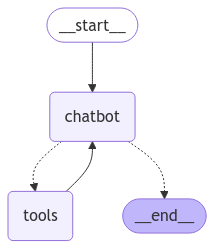

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

A thread is a unique ID or thread identifier assigned to each checkpoint saved by a checkpointer.

When invoking graph with a checkpointer, you **must** specify a thread_id as part of the configurable portion of the config:

In [11]:
config = {"configurable": {"thread_id": "1"}}

In [12]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! It's nice to meet you. I'm an AI assistant here to help you with whatever you'd like to know or discuss. 

Is there something specific I can help you with today? I can search for information, answer questions, or just chat. Let me know what you're interested in!


In [13]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Will! I remember that you introduced yourself in your first message. Is there something specific I can help you with today, Will?


In [14]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have any stored information about your name. Since we're starting a new conversation, I don't have access to any previous interactions we may have had.

Would you like to introduce yourself and tell me your name? Then I'll be able to address you properly in our conversation.


When interacting with the saved graph state, you **must specify** a thread identifier.

You can view the latest state of the graph by calling graph.get_state(config).

This will return a StateSnapshot object that corresponds to the latest checkpoint associated with the thread ID provided in the config or a checkpoint associated with a checkpoint ID for the thread, if provided.

In [15]:
snapshot = graph.get_state(config)
print(snapshot)

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='de1c6ef0-6c44-4c54-bb34-b56c60acf4fb'), AIMessage(content="Hi Will! It's nice to meet you. I'm an AI assistant here to help you with whatever you'd like to know or discuss. \n\nIs there something specific I can help you with today? I can search for information, answer questions, or just chat. Let me know what you're interested in!", additional_kwargs={}, response_metadata={'id': 'msg_01GaYUXn4obv3ZkfPucmaom8', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 424, 'output_tokens': 67, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-3-7-sonnet-20250219'}, id='run--77e7bd62-66c7-4368-9dd5-ffaea8dc28f6-0', usage_metadata

# Human-In-The-Loop

Agents can be unreliable and may need human input to successfully accomplish tasks.

Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph's **persistence layer supports human-in-the-loop workflows**, allowing execution to pause and resume based on user feedback.


The **interrupt** function in LangGraph enables human-in-the-loop workflows by pausing the graph at a specific node, presenting information to a human, and resuming the graph with their input.

This function is useful for tasks like approvals, edits, or collecting additional input.

The interrupt function is used in conjunction with the **Command** object to resume the graph with a value provided by the human.

We will make one change, which is to add a simple **human_assistance** tool accessible to the chatbot.

This tool uses interrupt to receive information from a human.

In [16]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Similar to Python's built-in input() function, calling interrupt inside the tool will pause execution.
# Progress is persisted based on our choice of checkpointer-- so if we are persisting with Postgres,
# we can resume at any time as long as the database is alive.
# Here we are persisting with the in-memory checkpointer,
# so we can resume any time as long as our Python kernel is running.

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
#llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", api_key=os.getenv("CLAUDE_API_KEY"))
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [17]:
user_input = "I need some expert guidance for building an AI agent. Could you request human assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request human assistance for me?
================================== Ai Message ==================================

[{'text': "I'd be happy to help you request human assistance for building an AI agent. To make this request more effective, it would be helpful to provide some specific details about what aspects of AI agent building you need guidance on.\n\nLet me request human assistance for you right away:", 'type': 'text'}, {'id': 'toolu_01NNXvvxpCL6Ybqnhp5MDbMx', 'input': {'query': 'User is requesting expert guidance for building an AI agent. They would benefit from human assistance in this area.'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01NNXvvxpCL6Ybqnhp5MDbMx)
 Call ID: toolu_01NNXvvxpCL6Ybqnhp5MDbMx
  Args:
    query: User is requesting expert guidance for building an AI agent. They would b

In [18]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

To resume execution, we pass a **Command** object containing data expected by the tool. The format of this data can be customized based on our needs.

Here, we just need a dict with a key "data":

In [19]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")

for event in events:
  if "messages" in event:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "I'd be happy to help you request human assistance for building an AI agent. To make this request more effective, it would be helpful to provide some specific details about what aspects of AI agent building you need guidance on.\n\nLet me request human assistance for you right away:", 'type': 'text'}, {'id': 'toolu_01NNXvvxpCL6Ybqnhp5MDbMx', 'input': {'query': 'User is requesting expert guidance for building an AI agent. They would benefit from human assistance in this area.'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01NNXvvxpCL6Ybqnhp5MDbMx)
 Call ID: toolu_01NNXvvxpCL6Ybqnhp5MDbMx
  Args:
    query: User is requesting expert guidance for building an AI agent. They would benefit from human assistance in this area.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to hel

# State Management

So far, we've relied on a simple state with one entry-- a list of messages.

You can go far with this simple state, but if you **want to define complex behavior** without relying on the message list, you can add additional fields to the state.

Here, we will populate the state keys inside of our human_assistance tool. This allows a human to review the information before it is stored in the state. We will again use Command, this time to issue a state update from inside our tool.

In [20]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

# Adding this information to the state makes it easily accessible by other
# graph nodes (e.g., a downstream node that stores or processes the information),
# as well as the graph's persistence layer.

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

@tool
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # Here, we will populate the state keys inside of our human_assistance tool.
    # This allows a human to review the information before it is stored in the state.

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }

    # We will again use Command, this time to issue a state update from inside our tool.
    return Command(update=state_update)

tool = TavilySearchResults(max_results=3)
tools = [tool, human_assistance]
#llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", api_key=os.getenv("CLAUDE_API_KEY"))
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


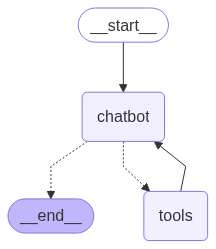

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer extract the name and birthday, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer extract the name and birthday, use the human_assistance tool for review.
================================== Ai Message ==================================

[{'text': "I'll look up when LangGraph was released for you and then use the human assistance tool as requested.\n\nLet me search for information about LangGraph's release date:", 'type': 'text'}, {'id': 'toolu_01BMEuwnbBUSxgME6MHbsqeU', 'input': {'query': 'when was LangGraph released date of first release'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01BMEuwnbBUSxgME6MHbsqeU)
 Call ID: toolu_01BMEuwnbBUSxgME6MHbsqeU
  Args:
    query: when was LangGraph released date of first release
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph St

In [22]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [23]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': 'Based on my search, I found that LangGraph was first launched in January 2023. According to the information from the LangChain blog, it was described as "a highly controllable, low-level orchestration framework for building agentic applications."\n\nThe search results also mention that after its initial release, LangGraph received significant investment and development, leading to a stable 0.1 release in June 2023.\n\nNow I\'ll use the human_assistance tool as requested:', 'type': 'text'}, {'id': 'toolu_01VUFv5omgHeSms1GbQxEA8n', 'input': {'name': 'LangGraph', 'birthday': 'January 2023'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01VUFv5omgHeSms1GbQxEA8n)
 Call ID: toolu_01VUFv5omgHeSms1GbQxEA8n
  Args:
    name: LangGraph
    birthday: January 2023
================================= Tool Message =================================
Name: human_assistanc

In [24]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

## Manually updating state

In [25]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f097c85-6b19-6847-8006-db41cb58341c'}}

In [26]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

# Time Travel

What if you want to let your user start from a previous response and "branch off" to explore a separate outcome? Or what if you want users to be able to "rewind" your assistant's work to fix some mistakes or try a different strategy (common in applications like autonomous software engineers)?

You can create both of these experiences and more using LangGraph's built-in "time travel" functionality.



In this section, you will "rewind" your graph by fetching a checkpoint using the graph's get_state_history method. You can then resume execution at this previous point in time.


In [27]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [28]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "I'd be happy to research LangGraph for you. Let me gather some information about it using the search tool available.", 'type': 'text'}, {'id': 'toolu_01GReCQahgmotrFg1Ss9vFtL', 'input': {'query': 'LangGraph AI framework LangChain'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01GReCQahgmotrFg1Ss9vFtL)
 Call ID: toolu_01GReCQahgmotrFg1Ss9vFtL
  Args:
    query: LangGraph AI framework LangChain
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Tutorial: Building LLM Agents with LangChain's ... - Zep", "url": "https://www.getzep.com/ai-agents/langgraph-tutorial/", "content": "## What is LangGraph?\n\nLangG

In [29]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That's an excellent idea! Building an autonomous agent with LangGraph is a great way to apply what you're learning and take advantage of its powerful state management and workflow capabilities.

Here are some thoughts on building an autonomous agent with LangGraph:

## Building an Autonomous Agent with LangGraph

### 1. Getting Started
- LangGraph is specifically designed for creating sophisticated autonomous agents that can maintain state and make complex decisions
- Its graph-based architecture is perfect for agents that need to navigate different decision paths

### 2. Components for Your Agent

**Core Components:**
- **State Definition**: Define what information your agent needs to remember
- **Nodes/Actions**: Define what your agent can do (search, analyze

You can get the **full history** of the graph execution for a given thread by calling graph.get_state_history(config).

This will return a list of StateSnapshot objects associated with the thread ID provided in the config.

Importantly, the checkpoints will be ordered chronologically with the most recent checkpoint / StateSnapshot being the first in the list.



In [30]:
to_replay = None

for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  12 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  11 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  10 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  10 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  9 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  8 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
-------------------------------------

In [31]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f097c8d-4633-6540-8005-ea7c63214319'}}


It's also possible to play-back a prior graph execution.

If we invoke a graph with a thread_id and a checkpoint_id, then we will **re-play **the previously executed steps before a checkpoint that corresponds to the checkpoint_id, and only execute the steps after the checkpoint.

- thread_id is the ID of a thread.
- checkpoint_id is an identifier that refers to a specific checkpoint within a thread.

Importantly, LangGraph knows whether a particular step has been executed previously.

If it has, LangGraph **simply re-plays** that particular step in the graph and **does not re-execute** the step, but only for the steps before the provided checkpoint_id.

All of the steps after checkpoint_id will be executed (i.e., a new fork), even if they have been executed previously.

In [32]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Let's search for information about how LangGraph integrates with LangChain:", 'type': 'text'}, {'id': 'toolu_013bYpx8tFE4ZaSVZJu3DPyh', 'input': {'query': 'LangGraph vs LangChain differences use cases examples'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_013bYpx8tFE4ZaSVZJu3DPyh)
 Call ID: toolu_013bYpx8tFE4ZaSVZJu3DPyh
  Args:
    query: LangGraph vs LangChain differences use cases examples
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangChain vs. LangGraph: A Comparative Analysis | by Tahir", "url": "https://medium.com/@tahirbalarabe2/%EF%B8%8Flangchain-vs-langgraph-a-comparative-analysis-ce7749a80d9c", "content": "If you’re building applications with large language models, you’ll likely come across two frameworks: LangChain and LangGraph. Whether